## Access Maps for Uruguay

- Origins: Population grid (Worldpop downsampled to 500 meters)
- Destinations: Cities, airports, border crossings, and ports

Typical access analysis with two adjustments:
    1. Extract different sets of destinations from OD
    2. Join travel time to origin grid based on "NN with the fastest route" (not necessarily closest NN)

### Load origins and graph

In [1]:
import os, sys, time, importlib

import geopandas as gpd
import pandas as pd
import networkx as nx
sys.path.append('/home/wb514197/GOSTnets')

import GOSTnets as gn
import rasterio as rio
from osgeo import gdal
import GOSTnets.calculate_od_raw as calcOD
import numpy as np

In [2]:
# This is a Jupyter Notebook extension which reloads all of the modules whenever you run the code
# This is optional but good if you are modifying and testing source code
%load_ext autoreload
%autoreload 2

In [4]:
# paths to data
pop_file = '/home/public/Data/PROJECTS/infraSAP_URY/origins/ury_ppp_2020_500mts_wgs.shp'
G_path = '/home/public/Data/PROJECTS/LAC_GOSTNets/graphs/URY/G_URY.pickle'
global_admin = '/home/public/Data/GLOBAL/ADMIN/g2015_0_simplified.shp'
# global_cities = '/home/public/Data/PROJECTS/LAC_GOSTNets/Destinations/Cities_centroids_FINAL_pop.shp'
global_cities = '/home/public/Data/GLOBAL/Population/Major_Cities.shp'
manual_edges_pth = os.path.join(os.path.expanduser("~"),'data/uruguay/edges/edges_manual.csv')

In [5]:
%%time
origins = gpd.read_file(pop_file)

CPU times: user 12.8 s, sys: 488 ms, total: 13.3 s
Wall time: 13.3 s


In [6]:
origins.head()

,pointid,grid_code,geometry
0,1,0.003990,POINT (-57.00451 -30.08037)
1,2,0.174111,POINT (-56.99912 -30.08037)
2,3,0.402564,POINT (-56.99372 -30.08037)
3,4,0.108120,POINT (-56.98832 -30.08036)
4,5,0.010809,POINT (-57.01531 -30.08506)


In [93]:
G = nx.read_gpickle(G_path)

#### Add critical edges connecting ports

In [95]:
manual_edges = pd.read_csv(manual_edges_pth).assign(length=manual_edges.length/1000).rename(columns={'WKT':'Wkt'})

In [96]:
manual_edges

,Wkt,stnode,endnode,infra_type,length,id,key,osm_id,Type
0,MULTILINESTRING ((-56.2140899054279 -34.902625...,new_obj_774,32193,tertiary,9.927328e-22,NaN,NaN,NaN,manual
1,MULTILINESTRING ((-56.2141123056184 -34.902602...,53223,32193,tertiary,1.164877e-21,NaN,NaN,NaN,manual
2,MULTILINESTRING ((-56.2141347058089 -34.902580...,new_obj_978,32193,tertiary,1.718098e-21,NaN,NaN,NaN,manual
3,MULTILINESTRING ((-57.8444597686854 -34.474910...,new_obj_5627,10453,tertiary,2.161150e-22,NaN,NaN,NaN,manual


In [98]:
def convert(x, attr_list):
    u = x['stnode']
    v = x['endnode']
    if u not in G:
        u = int(u)
#     data = {'Wkt':loads(x['Wkt'])}
    data = {'Wkt':x['Wkt']}
    for i in attr_list:
        data[i] = x[i]
    return (u, v, data)

def convert_vu(x, attr_list):
    u = x['stnode']
    v = x['endnode']
    if u not in G:
        u = int(u)
#     data = {'Wkt':loads(x['Wkt'])}
    data = {'Wkt':x['Wkt']}
    for i in attr_list:
        data[i] = x[i]
    return (v, u, data)

In [100]:
attr_list = list(manual_edges.columns[3:])
edge_bunch = manual_edges.apply(lambda x: convert(x, attr_list), axis = 1).tolist()
edge_bunch_vu = manual_edges.apply(lambda x: convert_vu(x, attr_list), axis = 1).tolist()

In [101]:
G.add_edges_from(edge_bunch)
G.add_edges_from(edge_bunch_vu)

[0, 0, 0, 0]

In [102]:
list_of_subgraphs = [G.subgraph(c).copy() for c in sorted(nx.strongly_connected_components(G), key=len, reverse=True)]

In [104]:
print(nx.info(G))

Name: 
Type: MultiDiGraph
Number of nodes: 10363
Number of edges: 35357
Average in degree:   3.4118
Average out degree:   3.4118


In [105]:
G_largest = list_of_subgraphs[0]

In [106]:
print(nx.info(G_largest))

Name: 
Type: MultiDiGraph
Number of nodes: 10232
Number of edges: 35227
Average in degree:   3.4428
Average out degree:   3.4428


#### Clip network 
(original graph included a buffer of roads from neighboring countries)

In [108]:
for u, v, data in G_largest.edges(data = True):
    if type(data['Wkt']) == list:
        data['Wkt'] = gn.unbundle_geometry(data['Wkt'])

In [129]:
from shapely.wkt import loads
for u, v, data in G_largest.edges(data = True):
    data['Wkt'] = loads(str(data['Wkt']))

In [113]:
inAdmin = gpd.read_file(global_admin)
inA = inAdmin[inAdmin['ISO3166_1_'] == "URY"].to_crs('epsg:32721')
inA_buff = inA.buffer(200).to_crs(inAdmin.crs)

In [132]:
G_clip = gn.clip(G_largest, inA_buff.iloc[0], geom_col = 'Wkt', largest_G = False)

/home/wb514197/.conda/envs/geo/lib/python3.7/site-packages/pyproj/crs/crs.py:55: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/home/wb514197/.conda/envs/geo/lib/python3.7/site-packages/pyproj/crs/crs.py:55: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


pre_clip | nodes: 10232 | edges: 35227
post_clip | nodes: 2149 | edges: 6973


In [159]:
gn.example_edge(G_clip)

(0, 1534, {'Wkt': <shapely.geometry.linestring.LineString object at 0x7fcfacb2d2d0>, 'id': 25415, 'infra_type': 'trunk_link', 'osm_id': '198703457', 'key': 'edge_25415', 'length': 0.10084182980054994, 'Type': 'destination_destruction'})


In [176]:
attr_list = list(G_clip[0][1534][0].keys())

#### Salt network

In [177]:
%%time
G_salt = gn.salt_long_lines(G_clip, source='epsg:4326', target='epsg:32721', thresh=5000, factor=1000, attr_list=attr_list)

/home/wb514197/.conda/envs/geo/lib/python3.7/site-packages/pyproj/crs/crs.py:55: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/home/wb514197/.conda/envs/geo/lib/python3.7/site-packages/pyproj/crs/crs.py:55: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/home/wb514197/.conda/envs/geo/lib/python3.7/site-packages/pyproj/crs/crs.py:55: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When m

Identified 425 unique edge(s) longer than 5000. 
Beginning new node creation...
4098 new edges added and 851 removed to bring total edges to 10220
1624 new nodes added to bring total nodes to 3773
CPU times: user 1min 28s, sys: 4.01 s, total: 1min 32s
Wall time: 1min 32s


In [178]:
G_time = gn.convert_network_to_time(G_salt, distance_tag = 'length', road_col = 'infra_type', factor = 1000)

In [181]:
gn.save(G_time, "G_URY_Processed", os.path.join(os.path.expanduser("~"),'data/uruguay/graph'))

In [44]:
# G_time = nx.read_gpickle(os.path.join(os.path.expanduser("~"),'data/uruguay/graph/G_URY_Processed.pickle'))

#### Select largest graph (again)

In [45]:
list_of_subgraphs = [G_time.subgraph(c).copy() for c in sorted(nx.strongly_connected_components(G_time), key=len, reverse=True)]

In [46]:
print(nx.info(G_time))

Name: 
Type: MultiDiGraph
Number of nodes: 3773
Number of edges: 10220
Average in degree:   2.7087
Average out degree:   2.7087


In [48]:
G_largest = list_of_subgraphs[0]

In [49]:
print(nx.info(G_largest))

Name: 
Type: MultiDiGraph
Number of nodes: 3748
Number of edges: 10184
Average in degree:   2.7172
Average out degree:   2.7172


### Prepare destinations

In [9]:
# inAdmin = gpd.read_file(global_admin)
# iso3 = 'URY'
# inA = inAdmin[inAdmin['ISO3166_1_'] == iso3]
# focalCities = inCities[inCities.intersects(inA.unary_union)]
inCities = gpd.read_file(global_cities)
dest_cities = inCities[inCities['CNTRY_NAME']=='Uruguay'].assign(dest_type = 'city')

In [10]:
len(dest_cities)

19

In [12]:
dests_path = '/home/public/Data/PROJECTS/infraSAP_URY/destinations'
dest_ports = gpd.read_file(os.path.join(dests_path, 'ports.geojson')).assign(dest_type = 'port')
dest_airports = gpd.read_file(os.path.join(dests_path, 'airports.geojson')).assign(dest_type = 'airport')
dest_borders = gpd.read_file(os.path.join(dests_path, 'border_control.geojson')).assign(dest_type = 'border')

In [13]:
dest_airports = dest_airports[dest_airports['aerodrome:type']=='international']
len(dest_airports)

7

In [14]:
dest_all = pd.concat([dest_cities, dest_ports, dest_airports, dest_borders], ignore_index=True)

In [15]:
dest_all.dest_type.value_counts()

city       19
border      8
airport     7
port        3
Name: dest_type, dtype: int64

In [16]:
dest_all.columns

Index(['ObjectID', 'CITY_NAME', 'GMI_ADMIN', 'ADMIN_NAME', 'FIPS_CNTRY',
       'CNTRY_NAME', 'STATUS', 'POP', 'POP_RANK', 'POP_CLASS', 'PORT_ID',
       'LABEL_FLAG', 'geometry', 'dest_type', 'id', '@id', 'amenity', 'name',
       'ferry', 'public_transport', 'aerodrome:type', 'aeroway', 'iata',
       'icao', 'name:en', 'operator:type', 'wikidata', 'wikipedia', 'source',
       'ele', 'operator', 'website', 'access', 'barrier', 'bicycle', 'foot',
       'horse', 'motorcar', 'motorcycle', 'vehicle'],
      dtype='object')

In [17]:
dest_all = dest_all[['ObjectID', 'CITY_NAME', 'POP', 'geometry', 'id', 'amenity', 'name', 'dest_type']]

In [58]:
dest_all.to_csv(os.path.join(output_path, 'destination_all.csv'))

In [18]:
len(origins), len(dest_all)

(653718, 37)

### Snap origins and destinations

#### Snap to origins to 5 nearest nodes

In [61]:
%%time
# this function returns a dictionary of origin IDs, with a list of 5 NNs, and a corresponding list of distances
origins_snapped_dict = gn.pandana_snap_to_many(G_largest, origins, source_crs='epsg:4326', target_crs='epsg:32721', add_dist_to_node_col = True,
                                         k_nearest=5, origin_id='pointid')

CPU times: user 1min 40s, sys: 868 ms, total: 1min 41s
Wall time: 1min 41s


In [275]:
# this is an example of the output
nn_map

{1: {'NN': ['519_192_939',
   '519_193_940',
   '519_191_938',
   '519_194_941',
   '519_195_942'],
  'NN_dist': [0.3508028872085103,
   0.3566449384170196,
   0.3737623408185705,
   0.380748703092603,
   0.4022035029778242]},
 2: {'NN': ['519_192_939',
   '519_193_940',
   '519_191_938',
   '519_194_941',
   '519_195_942'],
  'NN_dist': [0.3517235883193196,
   0.3567938957146764,
   0.37529099267949295,
   0.380246962535903,
   0.4011129799007898]},
 3: {'NN': ['519_192_939',
   '519_193_940',
   '519_191_938',
   '519_194_941',
   '519_195_942'],
  'NN_dist': [0.35272471359048874,
   0.3570246275439226,
   0.3768909667878996,
   0.3798214958825675,
   0.400092529958291]},
 4: {'NN': ['519_192_939',
   '519_193_940',
   '519_191_938',
   '519_194_941',
   '519_195_942'],
  'NN_dist': [0.3538055803074507,
   0.35733697549568827,
   0.3785613588040206,
   0.3794725596920932,
   0.39914269060855595]},
 5: {'NN': ['519_192_939',
   '519_193_940',
   '519_191_938',
   '519_194_941',
   '51

In [53]:
%%time
# we could use this later to check whether it played an effect
# origins_snapped = gn.pandana_snap_c(G_largest, origins, source_crs='epsg:4326', target_crs='epsg:32721',add_dist_to_node_col = True)

CPU times: user 35.2 s, sys: 140 ms, total: 35.3 s
Wall time: 35.3 s


In [54]:
dest_snapped = gn.pandana_snap_c(G_largest, dest_all, source_crs='epsg:4326', target_crs='epsg:32721',add_dist_to_node_col = False)

In [55]:
# origins_unique_nn = list(set(origins_snapped['NN']))
dest_nn = list(dest_snapped['NN'])

In [75]:
list_origins_NN = []
for each in origins_snapped_dict.values():
    list_origins_NN += each['NN']

In [80]:
origins_unique_nn = list(set(list_origins_NN))

In [81]:
len(set(origins_unique_nn))

3745

In [267]:
%%time
curOD = gn.calculate_OD(G_largest, origins_unique_nn, dest_nn, fail_value = 999999999)

CPU times: user 492 ms, sys: 1.92 ms, total: 494 ms
Wall time: 493 ms


In [268]:
curOD[curOD==999999999]

array([], dtype=float64)

In [269]:
curOD.shape

(3745, 37)

In [270]:
od_df = pd.DataFrame(curOD, index=origins_unique_nn, columns=dest_nn)

In [271]:
od_df.head()

,2067,798,154,845,2020,1970,377,1900,96_34_215,877,...,1964,1307,1984,1870_386_1838,2148,2087,2077,488,1853,2142
0,495866.917044,15825.405942,23810.093988,6523.586534,176081.602275,121965.834805,87318.767461,81452.643699,51149.596616,65947.625406,...,121675.567298,1859.317539,122854.079990,115186.475945,253493.722789,86440.425953,495702.687514,177798.994014,46706.864955,256885.992649
1,604511.090780,124469.579677,132592.072647,115167.760270,284863.580934,230747.813463,196100.746120,190234.622358,159793.770352,174591.799142,...,230457.545957,111232.585927,231636.058648,134147.573515,362275.701448,195222.404611,604346.861250,68141.424122,155488.843614,365530.166385
2,504765.938255,24724.427152,32709.115198,15422.607744,184980.623485,130864.856015,96217.788671,90351.664910,60048.617827,74846.646617,...,130574.588508,10758.338749,131753.101200,106777.227738,262392.744000,95339.447163,504601.708724,185046.010934,55605.886166,265785.013859
3,444379.230545,75868.580204,57638.792864,79725.395958,94932.216010,40816.448540,6169.381196,303.257435,121365.797358,106785.963677,...,40526.181033,79402.092650,41704.693725,196328.656752,172344.336525,5291.039688,444555.096392,258051.585395,34442.521309,321702.800308
4,477584.156488,17577.790916,34145.277703,11895.787849,186416.785990,132301.018520,97653.951176,91787.827415,32866.836060,47664.864851,...,132010.751013,16459.312253,133189.263705,133469.236501,263828.906505,96775.609668,477419.926958,195047.154763,57042.048671,238603.232093


For each origin set of 5 (k) possible NN:
    - Add snapping dist (in time) + time to a destination
    - Which destination? min time from all of them won't necessarily work, so we need to find the closest destination for each origin, and select the NN which yields the fastest travel time to that dest
    - closest_dest.idx should match the OD column order.

In [272]:
%%time
closest_dest = gn.pandana_snap_points(origins, dest_all, source_crs='epsg:4326', target_crs='epsg:32721', add_dist_to_node_col=True)

CPU times: user 33.7 s, sys: 751 ms, total: 34.5 s
Wall time: 34.5 s


In [273]:
closest_dest = closest_dest.set_index('pointid')

In [274]:
closest_dest.head()

,grid_code,geometry,idx,idx_dist
pointid,,,,
1,0.003990,POINT (499565.068 6672309.455),31,55951.010947
2,0.174111,POINT (500085.246 6672309.455),31,56451.891386
3,0.402564,POINT (500605.423 6672309.455),31,56953.117778
4,0.108120,POINT (501125.600 6672309.455),31,57454.681070
5,0.010809,POINT (498524.714 6671789.278),31,54809.044237


In [275]:
custom_speed = 20 # km/h

In [276]:
for pointid, items in list(origins_snapped_dict.items())[0:1]:
    dest_index = closest_dest.loc[pointid].idx
    nn_list = items['NN']
    dist_list = items['NN_dist']
    total_time_list = []
    for i in range(0, len(nn_list)):
        time_snapping = ((dist_list[i] / 1000) / custom_speed) * 60 * 60
        #time_to_dest = od_df.loc[nn_list[i]].min()
        time_to_dest = od_df.loc[nn_list[i]].iloc[dest_index]
        total_time = time_snapping+time_to_dest
        total_time_list.append(total_time)
        print(f"id: {nn_list[i]}, snapping dist (km): {dist_list[i]/1000:.2f}, time to dest (min): {(total_time/60)/60:.2f}")

id: 519_192_939, snapping dist (km): 38.75, time to dest (min): 37.98
id: 519_193_940, snapping dist (km): 39.52, time to dest (min): 41.48
id: 519_191_938, snapping dist (km): 41.03, time to dest (min): 34.62
id: 519_194_941, snapping dist (km): 42.14, time to dest (min): 45.08
id: 519_196_943, snapping dist (km): 44.33, time to dest (min): 52.12


In [277]:
%%time
fastest_nn = []
fastest_dist = []

for pointid, items in origins_snapped_dict.items():
    dest_index = closest_dest.loc[pointid].idx
    nn_list = items['NN']
    dist_list = items['NN_dist']
    total_time_list = []
    for i in range(0, len(nn_list)):
        time_snapping = ((dist_list[i] / 1000) / custom_speed) * 60 * 60
        #time_to_dest = od_df.loc[nn_list[i]].min()
        time_to_dest = od_df.loc[nn_list[i]].iloc[dest_index]
        total_time = time_snapping+time_to_dest
        total_time_list.append(total_time)
#         print(f"id: {nn_list[i]}, snapping dist (km): {dist_list[i]/1000:.2f}, time to dest (min): {(total_time/60)/60:.2f}")
    min_pos = total_time_list.index(min(total_time_list))
    fastest_nn.append(nn_list[min_pos])
    fastest_dist.append(dist_list[min_pos])
#     origins_snapped_smart.loc[pointid, "NN"] = nn_list[min_pos]
#     origins_snapped_smart.loc[pointid, "NN_dist"] = dist_list[min_pos]

CPU times: user 7min 44s, sys: 1.12 s, total: 7min 45s
Wall time: 7min 45s


In [278]:
origins_snapped_smart = origins.copy().set_index('pointid')

In [279]:
origins_snapped_smart['NN'] = pd.Series(fastest_nn, index = origins_snapped_smart.index)
origins_snapped_smart['NN_dist'] = pd.Series(fastest_dist, index = origins_snapped_smart.index)

In [280]:
origins_snapped_smart.head()

,grid_code,geometry,NN,NN_dist
pointid,,,,
1,0.003990,POINT (-57.00451 -30.08037),519_191_938,41025.341954
2,0.174111,POINT (-56.99912 -30.08037),519_191_938,41154.271592
3,0.402564,POINT (-56.99372 -30.08037),519_191_938,41289.352461
4,0.108120,POINT (-56.98832 -30.08036),519_191_938,41430.524395
5,0.010809,POINT (-57.01531 -30.08506),519_191_938,40278.638890


In [281]:
origins_snapped_smart['pointid'] = origins_snapped_smart.index

In [282]:
output_path = os.path.join(os.path.expanduser("~"),'data/uruguay')
origins_snapped_smart.to_csv(os.path.join(output_path,"origins_snapped_smart.csv"))

In [224]:
# origins_snapped.to_csv(os.path.join(output_path,"origins_snapped.csv"))

In [283]:
origins_snapped = origins_snapped_smart.copy()

In [284]:
custom_speed = 20 # km/h
origins_snapped['NN_dist_seconds'] = ((origins_snapped.NN_dist / 1000) / custom_speed) * 60 * 60
origins_snapped['NN_dist_hours'] = ((origins_snapped.NN_dist / 1000) / custom_speed)

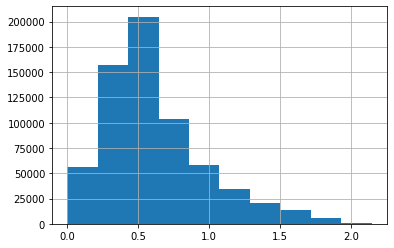

In [285]:
origins_snapped.NN_dist_hours.hist()

In [286]:
origins_join = origins_snapped.join(od_df, on='NN')

In [287]:
origins_join.head()

,grid_code,geometry,NN,NN_dist,pointid,NN_dist_seconds,NN_dist_hours,2067,798,154,...,1964,1307,1984,1870_386_1838,2148,2087,2077,488,1853,2142
pointid,,,,,,,,,,,,,,,,,,,,,
1,0.003990,POINT (-57.00451 -30.08037),519_191_938,41025.341954,1,7384.561552,2.051267,162610.566995,357637.243754,339407.456413,...,241242.482516,361170.7562,241048.374743,478097.320302,117254.175191,280262.843474,162786.432843,539820.248944,316211.184859,430752.569972
2,0.174111,POINT (-56.99912 -30.08037),519_191_938,41154.271592,2,7407.768887,2.057714,162610.566995,357637.243754,339407.456413,...,241242.482516,361170.7562,241048.374743,478097.320302,117254.175191,280262.843474,162786.432843,539820.248944,316211.184859,430752.569972
3,0.402564,POINT (-56.99372 -30.08037),519_191_938,41289.352461,3,7432.083443,2.064468,162610.566995,357637.243754,339407.456413,...,241242.482516,361170.7562,241048.374743,478097.320302,117254.175191,280262.843474,162786.432843,539820.248944,316211.184859,430752.569972
4,0.108120,POINT (-56.98832 -30.08036),519_191_938,41430.524395,4,7457.494391,2.071526,162610.566995,357637.243754,339407.456413,...,241242.482516,361170.7562,241048.374743,478097.320302,117254.175191,280262.843474,162786.432843,539820.248944,316211.184859,430752.569972
5,0.010809,POINT (-57.01531 -30.08506),519_191_938,40278.638890,5,7250.155000,2.013932,162610.566995,357637.243754,339407.456413,...,241242.482516,361170.7562,241048.374743,478097.320302,117254.175191,280262.843474,162786.432843,539820.248944,316211.184859,430752.569972


In [288]:
origins_join.to_csv(os.path.join(output_path, 'ODs', 'origins_join.csv'))

In [289]:
all(origins_join.columns[7:] == dest_snapped.NN)

True

In [290]:
origins_join_rename = origins_join.copy()

In [291]:
origins_join_rename.columns = pd.MultiIndex.from_arrays([['origin' for each in origins_snapped.columns]+list(dest_snapped.dest_type), origins_snapped.columns.append(dest_snapped.index)])

In [292]:
origins_join_rename.head()

origin                                                          \
        grid_code                     geometry           NN       NN_dist   
pointid                                                                     
1        0.003990  POINT (-57.00451 -30.08037)  519_191_938  41025.341954   
2        0.174111  POINT (-56.99912 -30.08037)  519_191_938  41154.271592   
3        0.402564  POINT (-56.99372 -30.08037)  519_191_938  41289.352461   
4        0.108120  POINT (-56.98832 -30.08036)  519_191_938  41430.524395   
5        0.010809  POINT (-57.01531 -30.08506)  519_191_938  40278.638890   

                                                        city                 \
        pointid NN_dist_seconds NN_dist_hours              0              1   
pointid                                                                       
1             1     7384.561552      2.051267  162610.566995  357637.243754   
2             2     7407.768887      2.057714  162610.566995  357637.243754   
3             3     7432.083443      2.064468  162610.566995  357637.243754   
4             4     7457.494391      2.071526  162610.566995  357637.243754   
5             5     7250.155000      2.013932  162610.566995  357637.243754   

                        ...        airport                      border  \
                     2  ...             27           28             29   
pointid                 ...                                              
1        339407.456413  ...  241242.482516  361170.7562  241048.374743   
2        339407.456413  ...  241242.482516  361170.7562  241048.374743   
3        339407.456413  ...  241242.482516  361170.7562  241048.374743   
4        339407.456413  ...  241242.482516  361170.7562  241048.374743   
5        339407.456413  ...  241242.482516  361170.7562  241048.374743   

                                                                     \
                    30             31             32             33   
pointid                                                               
1        478097.320302  117254.175191  280262.843474  162786.432843   
2        478097.320302  117254.175191  280262.843474  162786.432843   
3        478097.320302  117254.175191  280262.843474  162786.432843   
4        478097.320302  117254.175191  280262.843474  162786.432843   
5        478097.320302  117254.175191  280262.843474  162786.432843   

                                                      
                    34             35             36  
pointid                                               
1        539820.248944  316211.184859  430752.569972  
2        539820.248944  316211.184859  430752.569972  
3        539820.248944  316211.184859  430752.569972  
4        539820.248944  316211.184859  430752.569972  
5        539820.248944  316211.184859  430752.569972  

[5 rows x 44 columns]

Add snapping time to each column (speed of 20 km/h)

In [293]:
# origins_join2 = origins_join_rename.copy()
origins_join2 = origins_join_rename.apply(lambda x: x + origins_join_rename.origin.NN_dist_seconds if x.name[1] in dest_snapped.index else x)

In [294]:
origins_join2.head()

origin                                                          \
        grid_code                     geometry           NN       NN_dist   
pointid                                                                     
1        0.003990  POINT (-57.00451 -30.08037)  519_191_938  41025.341954   
2        0.174111  POINT (-56.99912 -30.08037)  519_191_938  41154.271592   
3        0.402564  POINT (-56.99372 -30.08037)  519_191_938  41289.352461   
4        0.108120  POINT (-56.98832 -30.08036)  519_191_938  41430.524395   
5        0.010809  POINT (-57.01531 -30.08506)  519_191_938  40278.638890   

                                                        city                 \
        pointid NN_dist_seconds NN_dist_hours              0              1   
pointid                                                                       
1             1     7384.561552      2.051267  169995.128547  365021.805306   
2             2     7407.768887      2.057714  170018.335882  365045.012640   
3             3     7432.083443      2.064468  170042.650438  365069.327197   
4             4     7457.494391      2.071526  170068.061386  365094.738145   
5             5     7250.155000      2.013932  169860.721996  364887.398754   

                        ...        airport                        border  \
                     2  ...             27             28             29   
pointid                 ...                                                
1        346792.017965  ...  248627.044068  368555.317752  248432.936295   
2        346815.225300  ...  248650.251403  368578.525087  248456.143630   
3        346839.539857  ...  248674.565960  368602.839643  248480.458187   
4        346864.950805  ...  248699.976908  368628.250591  248505.869135   
5        346657.611414  ...  248492.637517  368420.911200  248298.529744   

                                                                     \
                    30             31             32             33   
pointid                                                               
1        485481.881853  124638.736743  287647.405026  170170.994394   
2        485505.089188  124661.944078  287670.612361  170194.201729   
3        485529.403745  124686.258634  287694.926917  170218.516286   
4        485554.814693  124711.669583  287720.337865  170243.927234   
5        485347.475302  124504.330192  287512.998474  170036.587843   

                                                      
                    34             35             36  
pointid                                               
1        547204.810496  323595.746411  438137.131523  
2        547228.017831  323618.953746  438160.338858  
3        547252.332387  323643.268302  438184.653415  
4        547277.743335  323668.679250  438210.064363  
5        547070.403945  323461.339859  438002.724972  

[5 rows x 44 columns]

In [295]:
origins_join2.to_csv(os.path.join(output_path, 'ODs', 'origins_join2.csv'))

In [296]:
od_cities = np.array(origins_join2['city'])
od_ports = np.array(origins_join2['port'])
od_airports = np.array(origins_join2['airport'])
od_borders = np.array(origins_join2['border'])

In [297]:
np.save(os.path.join(output_path, "ODs", "OD_URY.npy"), curOD)

### Calculate gravity

In [298]:
%%time
access_cities = calcOD.calculate_gravity(od_cities, dWeight = dest_all.POP[origins_join2['city'].columns])

CPU times: user 13min 1s, sys: 3.83 s, total: 13min 5s
Wall time: 13min 5s


In [299]:
access_ports = calcOD.calculate_gravity(od_ports)
access_airports = calcOD.calculate_gravity(od_airports)
access_borders = calcOD.calculate_gravity(od_borders)

In [300]:
access_cities_results = origins_snapped.join(access_cities).rename(columns = {
        'd_0.01': 'd_1',
        'd_0.005': 'd_2',
        'd_0.001' : 'd_3',
        'd_0.0007701635' : 'd_4',   # Market access halves every 15 mins
        'd_0.0003850818' : 'd_5',   # Market access halves every 30 mins
        'd_0.0001925409' : 'd_6',   # Market access halves every 60 mins
        'd_9.62704e-05' : 'd_7',   # Market access halves every 120 mins
        'd_3.85082e-05' : 'd_8',   # Market access halves every 300 mins
        'd_1e-05' : 'd_9'
    })
access_ports_results = origins_snapped.join(access_ports).rename(columns = {
        'd_0.01': 'd_1',
        'd_0.005': 'd_2',
        'd_0.001' : 'd_3',
        'd_0.0007701635' : 'd_4',   # Market access halves every 15 mins
        'd_0.0003850818' : 'd_5',   # Market access halves every 30 mins
        'd_0.0001925409' : 'd_6',   # Market access halves every 60 mins
        'd_9.62704e-05' : 'd_7',   # Market access halves every 120 mins
        'd_3.85082e-05' : 'd_8',   # Market access halves every 300 mins
        'd_1e-05' : 'd_9'
    })
access_airports_results = origins_snapped.join(access_airports).rename(columns = {
        'd_0.01': 'd_1',
        'd_0.005': 'd_2',
        'd_0.001' : 'd_3',
        'd_0.0007701635' : 'd_4',   # Market access halves every 15 mins
        'd_0.0003850818' : 'd_5',   # Market access halves every 30 mins
        'd_0.0001925409' : 'd_6',   # Market access halves every 60 mins
        'd_9.62704e-05' : 'd_7',   # Market access halves every 120 mins
        'd_3.85082e-05' : 'd_8',   # Market access halves every 300 mins
        'd_1e-05' : 'd_9'
    })
access_borders_results = origins_snapped.join(access_borders).rename(columns = {
        'd_0.01': 'd_1',
        'd_0.005': 'd_2',
        'd_0.001' : 'd_3',
        'd_0.0007701635' : 'd_4',   # Market access halves every 15 mins
        'd_0.0003850818' : 'd_5',   # Market access halves every 30 mins
        'd_0.0001925409' : 'd_6',   # Market access halves every 60 mins
        'd_9.62704e-05' : 'd_7',   # Market access halves every 120 mins
        'd_3.85082e-05' : 'd_8',   # Market access halves every 300 mins
        'd_1e-05' : 'd_9'
    })

In [301]:
output_path = os.path.join(os.path.expanduser("~"),'data/uruguay/access')

access_cities_results.to_csv(os.path.join(output_path,"access_cities.csv"))
access_ports_results.to_csv(os.path.join(output_path,"access_ports.csv"))
access_airports_results.to_csv(os.path.join(output_path,"access_airports.csv"))
access_borders_results.to_csv(os.path.join(output_path,"access_borders.csv"))

#### Reload

In [3]:
# def load_csv(csv_path, geometry = 'geometry', crs = 'epsg:4326'):
#     df = pd.read_csv(csv_path)
#     df[geometry] = df[geometry].apply(loads)
#     gdf = gpd.GeoDataFrame(df, crs = crs)
#     return(gdf)

In [4]:
# from shapely.wkt import loads
# output_path = os.path.join(os.path.expanduser("~"),'data/uruguay/access')

# access_cities_results = load_csv(os.path.join(output_path,"access_cities.csv"))
# access_ports_results = load_csv(os.path.join(output_path,"access_ports.csv"))
# access_airports_results = load_csv(os.path.join(output_path,"access_airports.csv"))
# access_borders_results = load_csv(os.path.join(output_path,"access_borders.csv"))

#### Convert to raster and save results

In [302]:
from GOSTnets.conversion_utils import rasterize_od_results

In [303]:
access_cities_results_utm = access_cities_results.to_crs('epsg:32721')
access_ports_results_utm = access_ports_results.to_crs('epsg:32721')
access_airports_results_utm = access_airports_results.to_crs('epsg:32721')
access_borders_results_utm = access_borders_results.to_crs('epsg:32721')

In [304]:
data_path = '/home/public/Data/PROJECTS/infraSAP_URY'
raster_path = os.path.join(data_path, 'origins', 'ury_ppp_2020_UNadj_agg6.tif')
output_path = os.path.join(os.path.expanduser("~"),'data/uruguay/access')

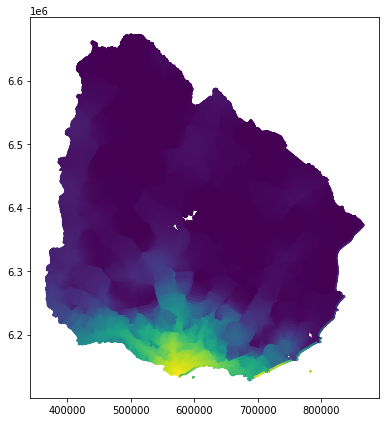

In [258]:
access_cities_results_utm.plot(column='d_8', figsize=(7,7), markersize=1)

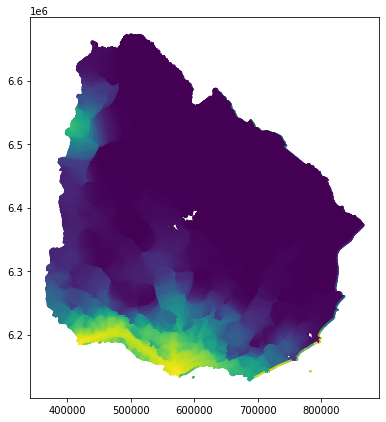

In [260]:
access_ports_results_utm.plot(column='d_8', figsize=(7,7), markersize=1)

In [305]:
for d in range(5,10):
    print(f'writing {d}')
    rasterize_od_results(access_cities_results_utm, os.path.join(output_path,f"access_cities_d{d}.tif"),f'd_{d}', template=raster_path)
    rasterize_od_results(access_ports_results_utm, os.path.join(output_path,f"access_ports_d{d}.tif"),f'd_{d}', template=raster_path)
    rasterize_od_results(access_airports_results_utm, os.path.join(output_path,f"access_airports_d{d}.tif"),f'd_{d}', template=raster_path)
    rasterize_od_results(access_borders_results_utm, os.path.join(output_path,f"access_borders_d{d}.tif"),f'd_{d}', template=raster_path)

writing 5
writing 6
writing 7
writing 8
writing 9
